# 🚦 Verkehrsprognose – Phase U: Die Daten verstehen

Bevor ein Modell Verkehr vorhersagen kann, prüfen wir die Datenqualität und analysieren Muster.

💡 Wichtigste Regel: Schlechte Daten → schlechte Vorhersagen.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import display

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('tab10')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 12

print("✅ Alle Werkzeuge erfolgreich geladen!")

✅ Alle Werkzeuge erfolgreich geladen!


## 🔧 Schritt 1: Verkehrsdaten simulieren

Wir erzeugen 420 Tage mit stündlichen Messungen (10.080 Werte).

Berücksichtigte Effekte:
- 🕗 Rush Hour
- 📅 Wochenende
- ☀️ Wetter
- 📈 Trend
- 🗓️ Jahreszeit
- 🎉 Feiertage

In [2]:
np.random.seed(42)

N = 10_080
start = pd.Timestamp("2023-01-01")
ds = pd.date_range(start=start, periods=N, freq="h")

hour = ds.hour.values
weekday = ds.dayofweek.values
month = ds.month.values

weather_options = ["sunny", "cloudy", "rainy"]
weather_raw = np.random.choice([0,1,2], size=N, p=[0.5,0.3,0.2])
weather = np.array(weather_options)[weather_raw]

trend = np.linspace(0, 8, N)
seasonal_year = 5 * np.sin(2*np.pi*(ds.dayofyear.values/365 - 0.25))

hour_effect = (
    28 * np.exp(-0.5*((hour-8)/1.5)**2) +
    22 * np.exp(-0.5*((hour-17)/1.5)**2)
)

weekend_effect = np.where(weekday >= 5, -18, 0)
weather_effect = np.where(weather == "rainy", -12,
                 np.where(weather == "sunny", 6, 0))

np.random.seed(7)
holiday_days = np.random.choice(np.arange(N//24), size=15, replace=False)
holiday_mask = np.zeros(N)
for d in holiday_days:
    holiday_mask[d*24:(d+1)*24] = -20

noise = np.random.normal(0, 6, N)

base = 50
y = (base + trend + seasonal_year + hour_effect +
     weekend_effect + weather_effect + holiday_mask + noise
    ).clip(5,120).astype(int)

df = pd.DataFrame({
    "ds": ds,
    "y": y,
    "hour": hour,
    "weekday": weekday,
    "month": month,
    "weather": weather
})

print("✅ Datensatz erstellt")
print(df.head())

✅ Datensatz erstellt
                   ds   y  hour  weekday  month weather
0 2023-01-01 00:00:00  35     0        6      1   sunny
1 2023-01-01 01:00:00  22     1        6      1   rainy
2 2023-01-01 02:00:00  33     2        6      1  cloudy
3 2023-01-01 03:00:00  25     3        6      1  cloudy
4 2023-01-01 04:00:00  30     4        6      1   sunny


## 1️⃣ Sind die Daten vollständig und korrekt?

Wir prüfen:
- Größe
- Datentypen
- Fehlende Werte
- Duplikate

In [3]:
print("📐 Größe:", df.shape)

display(df.dtypes)

print("Fehlende Werte:")
display(df.isnull().sum())

print("Duplikate:", df.duplicated().sum())

📐 Größe: (10080, 6)


ds         datetime64[us]
y                   int64
hour                int32
weekday             int32
month               int32
weather               str
dtype: object

Fehlende Werte:


ds         0
y          0
hour       0
weekday    0
month      0
weather    0
dtype: int64

Duplikate: 0


## 2️⃣ Wie viele Autos fahren typischerweise?

Wir untersuchen:
- Durchschnitt
- Streuung
- Histogramm
- Boxplot

count    10080.000000
mean        55.568948
std         16.054149
min          5.000000
25%         45.000000
50%         56.000000
75%         66.000000
max        103.000000
Name: y, dtype: float64


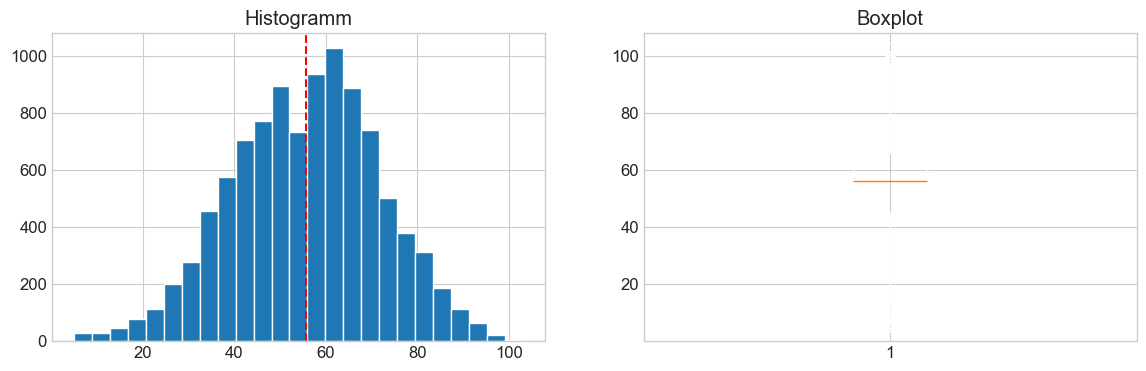

In [4]:
stats = df["y"].describe()
print(stats)

fig, axes = plt.subplots(1,2, figsize=(14,4))

axes[0].hist(df["y"], bins=25, edgecolor="white")
axes[0].axvline(df["y"].mean(), color="red", linestyle="--")
axes[0].set_title("Histogramm")

axes[1].boxplot(df["y"])
axes[1].set_title("Boxplot")

plt.show()

### 📊 Was zeigt dieses Diagramm?

Dieses Diagramm zeigt, **wie sich die gemessenen Fahrzeugzahlen insgesamt verteilen**.

#### 🔹 Histogramm (links)
Hier sehen wir:
- Wie oft bestimmte Verkehrswerte vorkommen.
- Ob es viele „normale“ Stunden gibt oder viele extreme Spitzen.

👉 Wenn die meisten Werte in einem stabilen Bereich liegen, bedeutet das:
Das Verkehrsaufkommen ist **planbar und berechenbar**.

#### 🔹 Boxplot (rechts)
Der Boxplot zeigt:
- Den typischen Bereich der Werte (mittlere 50%)
- Den Median (typischer Wert)
- Mögliche Ausreißer

👉 Für Kunden wichtig:
- Keine extremen Ausreißer bedeutet:
  Das Modell wird **stabiler und zuverlässiger arbeiten**.
- Extreme Einzelwerte können Modelle verzerren – hier ist das kaum der Fall.

### 💼 Geschäftlicher Nutzen
Eine gleichmäßige Verteilung bedeutet:
- Gute Prognosefähigkeit
- Weniger Überraschungen
- Stabilere Verkehrssteuerung

## 3️⃣ Zeitliche Muster

Wir betrachten:
- Gesamtverlauf
- Tagesrhythmus
- Wochenrhythmus
- Jahresrhythmus

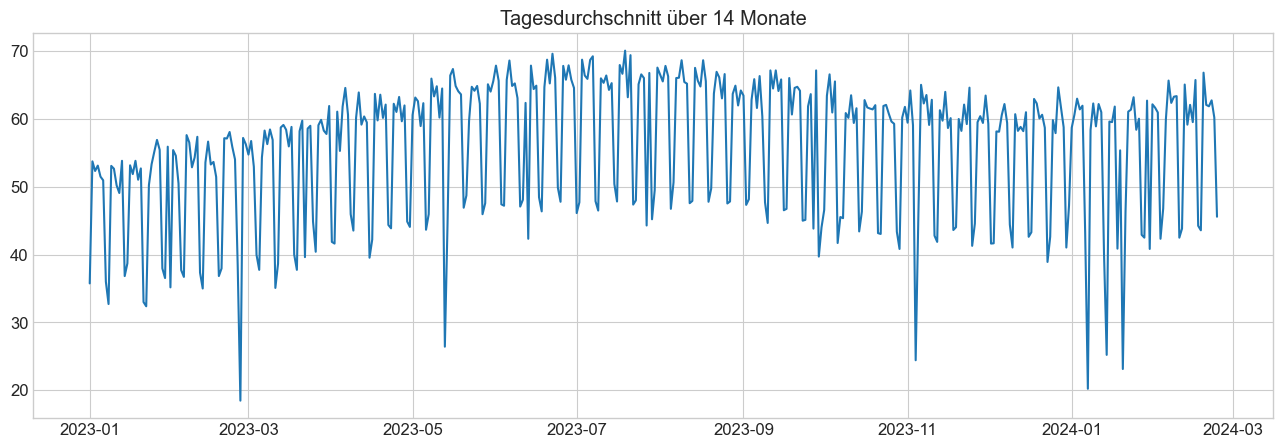

In [5]:
df_daily = df.groupby(df["ds"].dt.date)["y"].mean().reset_index()
df_daily["ds"] = pd.to_datetime(df_daily["ds"])

plt.figure(figsize=(16,5))
plt.plot(df_daily["ds"], df_daily["y"])
plt.title("Tagesdurchschnitt über 14 Monate")
plt.show()

### 📈 Was zeigt dieser Langzeit-Überblick?

Hier sehen wir den durchschnittlichen Verkehr pro Tag über 14 Monate.

#### 🔎 Was fällt auf?
- Der Verkehr steigt leicht über die Zeit.
- Es gibt regelmäßige Schwankungen.
- Keine chaotischen oder zufälligen Muster.

👉 Das bedeutet:
Der Verkehr folgt einem **Trend** und ist nicht zufällig.

### 💼 Geschäftlicher Nutzen
- Langfristige Planung wird möglich.
- Infrastruktur kann frühzeitig angepasst werden.
- Wachstumstrends lassen sich erkennen.

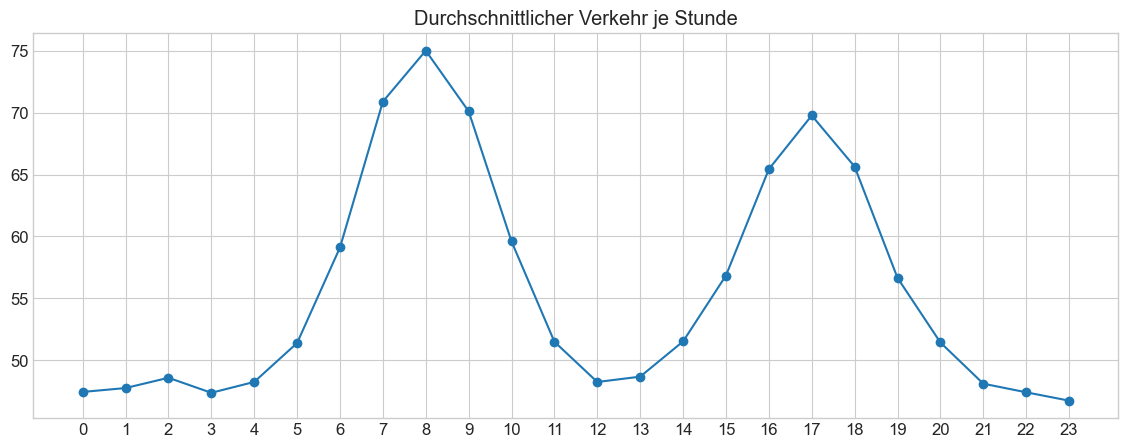

In [6]:
hour_avg = df.groupby("hour")["y"].mean()

plt.plot(hour_avg.index, hour_avg.values, marker="o")
plt.title("Durchschnittlicher Verkehr je Stunde")
plt.xticks(range(24))
plt.show()

### 🕒 Wann ist am meisten Verkehr?

Dieses Diagramm zeigt den durchschnittlichen Verkehr je Uhrzeit.

#### 🔎 Was erkennen wir?
- Morgens (ca. 7–9 Uhr): starke Spitze → Berufsverkehr
- Abends (ca. 16–18 Uhr): zweite Spitze → Heimverkehr
- Nachts: sehr niedriger Verkehr

👉 Die Uhrzeit ist der **stärkste Einflussfaktor**.

### 💼 Geschäftlicher Nutzen
- Ampelschaltungen können gezielt optimiert werden.
- Ressourcen (z. B. Personal, Verkehrsmanagement) können auf Stoßzeiten fokussiert werden.
- Baustellenplanung kann auf schwache Zeiten gelegt werden.

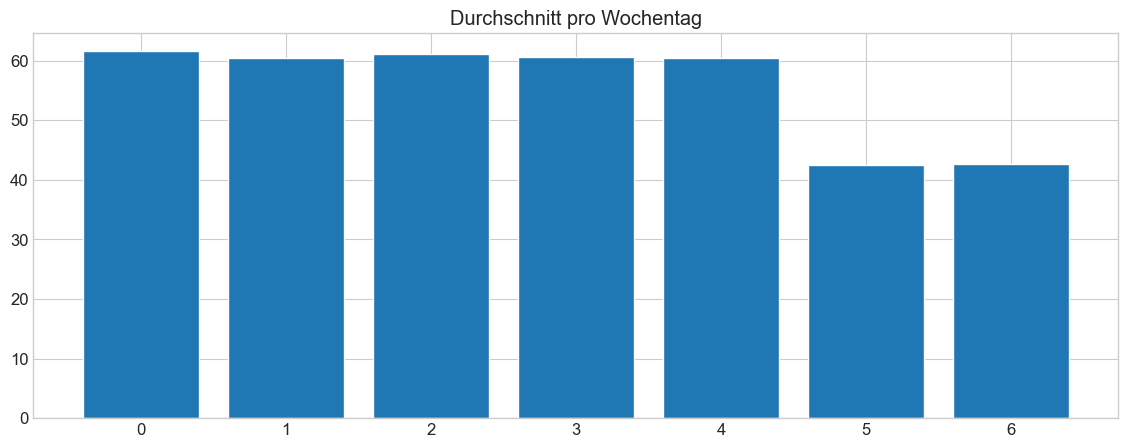

In [7]:
weekday_avg = df.groupby("weekday")["y"].mean()

plt.bar(range(7), weekday_avg.values)
plt.title("Durchschnitt pro Wochentag")
plt.show()

df["is_weekend"] = (df["weekday"] >= 5).astype(int)

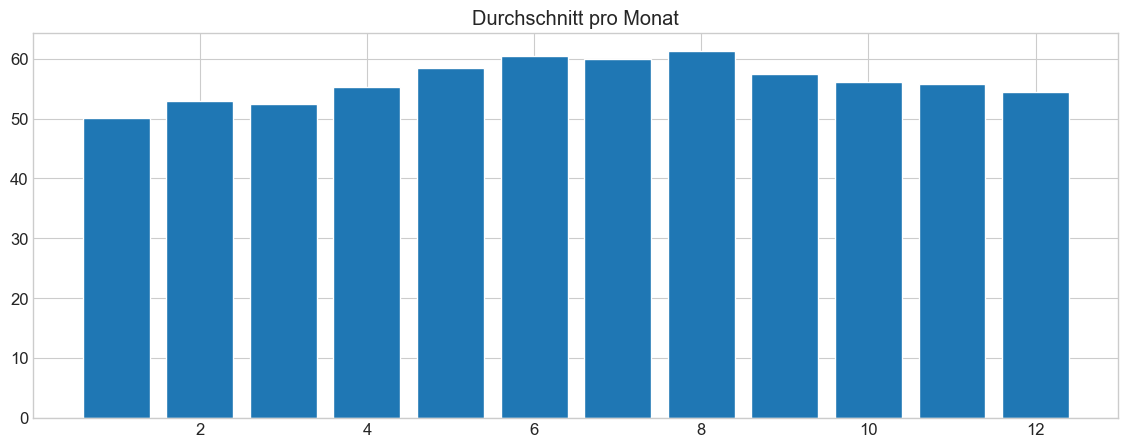

In [8]:
month_avg = df.groupby("month")["y"].mean()

plt.bar(month_avg.index, month_avg.values)
plt.title("Durchschnitt pro Monat")
plt.show()

### 📅 Unterschied zwischen Werktag und Wochenende

Hier sehen wir den durchschnittlichen Verkehr pro Wochentag.

#### 🔎 Erkenntnis:
- Werktage deutlich stärker belastet
- Wochenende spürbar ruhiger

👉 Verkehr ist stark vom Arbeitsrhythmus abhängig.

### 💼 Geschäftlicher Nutzen
- Unterschiedliche Steuerungslogiken für Werktag vs. Wochenende sinnvoll
- Energie- und Betriebskosten können am Wochenende reduziert werden
- Events am Wochenende wirken sich anders aus als unter der Woche

## 4️⃣ Wetteranalyse

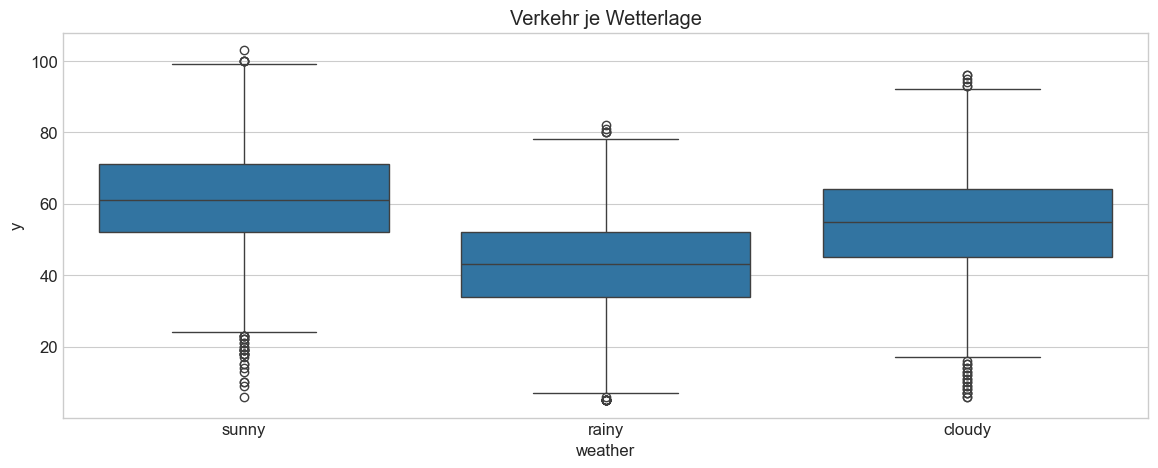

In [9]:
sns.boxplot(data=df, x="weather", y="y")
plt.title("Verkehr je Wetterlage")
plt.show()

### 🌦 Beeinflusst das Wetter den Verkehr?

Hier vergleichen wir den Verkehr bei:
- ☀️ Sonne
- ⛅ Bewölkung
- 🌧 Regen

#### 🔎 Erkenntnis:
- Bei Regen sinkt das Verkehrsaufkommen messbar.
- Sonnige Tage haben leicht erhöhten Verkehr.

👉 Das Wetter ist ein **messbarer Einflussfaktor**.

### 💼 Geschäftlicher Nutzen
- Prognosen können durch Wetterdaten deutlich verbessert werden.
- Frühwarnsysteme bei starkem Regen möglich.
- Verkehrssteuerung kann dynamisch angepasst werden.

## 6️⃣ Daten für das Modell vorbereiten

Wir erzeugen:
- Lag-Features
- Zyklische Uhrzeit
- Rolling Means

In [10]:
df["lag_1"] = df["y"].shift(1)
df["lag_24"] = df["y"].shift(24)

df[["y","lag_1","lag_24"]].corr()

,y,lag_1,lag_24
y,1.000000,0.624251,0.437889
lag_1,0.624251,1.000000,0.390238
lag_24,0.437889,0.390238,1.000000


In [11]:
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)

In [12]:
df["rolling_mean_3h"] = df["y"].shift(1).rolling(3).mean()
df["rolling_mean_12h"] = df["y"].shift(1).rolling(12).mean()

## 9️⃣ Finaler Datensatz für das Modell

In [13]:
feature_cols = [
    "ds","y","hour","hour_sin","hour_cos",
    "weekday","is_weekend","month","weather",
    "lag_1","lag_24","rolling_mean_3h","rolling_mean_12h"
]

df_final = df[feature_cols].dropna().reset_index(drop=True)

print("Finale Größe:", df_final.shape)
display(df_final.head())

Finale Größe: (10056, 13)


,ds,y,hour,hour_sin,hour_cos,weekday,is_weekend,month,weather,lag_1,lag_24,rolling_mean_3h,rolling_mean_12h
0,2023-01-02 00:00:00,50,0,0.000000,1.000000,0,0,1,sunny,27.0,35.0,32.000000,36.333333
1,2023-01-02 01:00:00,48,1,0.258819,0.965926,0,0,1,cloudy,50.0,22.0,35.666667,38.583333
2,2023-01-02 02:00:00,58,2,0.500000,0.866025,0,0,1,sunny,48.0,33.0,41.666667,40.083333
3,2023-01-02 03:00:00,50,3,0.707107,0.707107,0,0,1,cloudy,58.0,25.0,52.000000,42.000000
4,2023-01-02 04:00:00,35,4,0.866025,0.500000,0,0,1,cloudy,50.0,30.0,52.000000,43.416667


### 🔥 Die „Landkarte des Verkehrs“

Diese Heatmap kombiniert:
- Wochentag (Zeilen)
- Uhrzeit (Spalten)
- Farbe = Verkehrsstärke

#### 🔎 Dunkelrot bedeutet:
Hohe Verkehrsbelastung

#### 🔎 Hell bedeutet:
Geringe Belastung

👉 Auf einen Blick sieht man:
- Rush Hour an Werktagen
- Ruhige Wochenenden
- Nachts fast kein Verkehr

### 💼 Geschäftlicher Nutzen
- Schnelle Entscheidungsgrundlage für Maßnahmen
- Belastungsschwerpunkte sofort erkennbar
- Ideal für Präsentationen vor Entscheidungsträgern

### 🔁 Wiederholt sich Verkehr?

Dieses Diagramm zeigt:
Wie stark der Verkehr von früheren Stunden abhängt.

#### 🔎 Wichtige Erkenntnis:
- Der Verkehr der letzten Stunde beeinflusst die aktuelle Stunde stark.
- Der Verkehr vor 24 Stunden (gestern gleiche Uhrzeit) ist besonders aussagekräftig.

👉 Verkehr folgt klaren Mustern.

### 💼 Geschäftlicher Nutzen
- Prognosen sind realistisch möglich.
- Muster wiederholen sich täglich.
- Modelle können aus der Vergangenheit lernen.

### ⏱ Warum glätten wir den Verkehr?

Die roten und grünen Linien zeigen:
- Kurzfristigen Durchschnitt (3 Stunden)
- Längerfristigen Durchschnitt (12 Stunden)

#### 🔎 Warum ist das wichtig?
Einzelne extreme Stunden können zufällig sein.
Der gleitende Durchschnitt zeigt das „Grundniveau“.

👉 Das Modell wird robuster.

### 💼 Geschäftlicher Nutzen
- Weniger Fehlalarme
- Stabilere Prognosen
- Bessere operative Entscheidungen